Nama : Fitria Desiyani <br>
NIM : 211351057 <br>
Kelas : IF Pagi B

# import Dataset

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fitriadess","key":"8c1c17e5fd700b4be0514ccb0e390e8a"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d codebreaker619/hepatitis-data

  0% 0.00/2.55k [00:00<?, ?B/s]
100% 2.55k/2.55k [00:00<00:00, 4.80MB/s]


In [4]:
!mkdir hepatitis-data
!unzip hepatitis-data.zip -d hepatitis-data
!ls hepatitis-data

Archive:  hepatitis-data.zip
  inflating: hepatitis-data/hepatitis_csv.csv  
hepatitis_csv.csv


# import library yang digunakan

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from plotly.subplots import make_subplots

In [7]:
import pickle

# Data Discovery

In [8]:
df = pd.read_csv("/content/hepatitis-data/hepatitis_csv.csv")

In [9]:
df.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,male,False,False,False,False,False,False,False,False,False,False,False,1.0,85.0,18.0,4.0,NaN,False,live
1,50,female,False,False,True,False,False,False,False,False,False,False,False,0.9,135.0,42.0,3.5,NaN,False,live
2,78,female,True,False,True,False,False,True,False,False,False,False,False,0.7,96.0,32.0,4.0,NaN,False,live
3,31,female,NaN,True,False,False,False,True,False,False,False,False,False,0.7,46.0,52.0,4.0,80.0,False,live
4,34,female,True,False,False,False,False,True,False,False,False,False,False,1.0,NaN,200.0,4.0,NaN,False,live


In [14]:
df.isna().sum()

age                 0
sex                 0
steroid             1
antivirals          0
fatigue             1
malaise             1
anorexia            1
liver_big          10
liver_firm         11
spleen_palpable     5
spiders             5
ascites             5
varices             5
bilirubin           6
alk_phosphate      29
sgot                4
albumin            16
protime            66
histology           0
class               0
dtype: int64

In [15]:
df.fillna(df.mode(), inplace = True)

In [16]:
df.fillna(df.mean(), inplace = True)

<ipython-input-16-af658eae1e37>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(df.mean(), inplace = True)


In [17]:
df.isna().any()

age                False
sex                False
steroid            False
antivirals         False
fatigue            False
malaise            False
anorexia           False
liver_big          False
liver_firm         False
spleen_palpable    False
spiders            False
ascites            False
varices            False
bilirubin          False
alk_phosphate      False
sgot               False
albumin            False
protime            False
histology          False
class              False
dtype: bool

# EDA (minimal 5)

In [19]:
class_counts = df['class'].value_counts()

print('Class distribution:')
print(class_counts)

Class distribution:
live    123
die      32
Name: class, dtype: int64


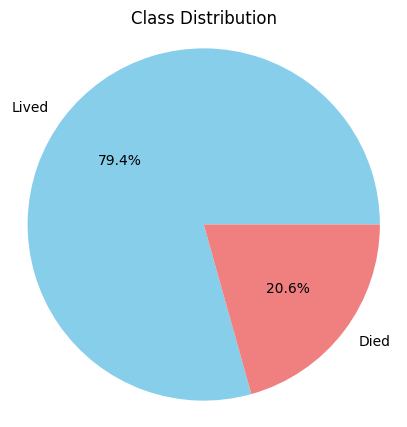

In [20]:
plt.figure(figsize=(5, 5))
plt.pie(class_counts, labels=['Lived', 'Died'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.

# Show the pie chart
plt.show()

<Figure size 2000x1000 with 0 Axes>

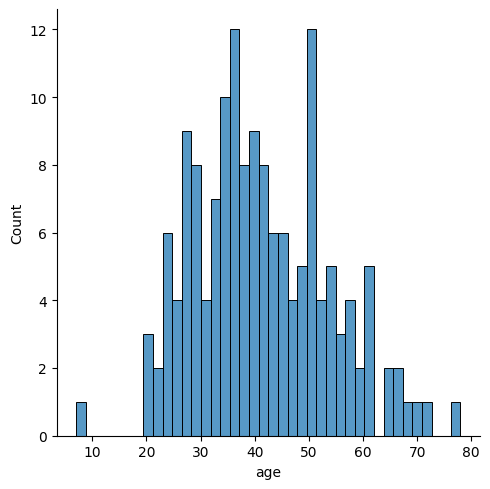

In [21]:
plt.figure(figsize=(20, 10))
sns.displot(df.age, bins=40)

<Axes: xlabel='bilirubin', ylabel='Density'>

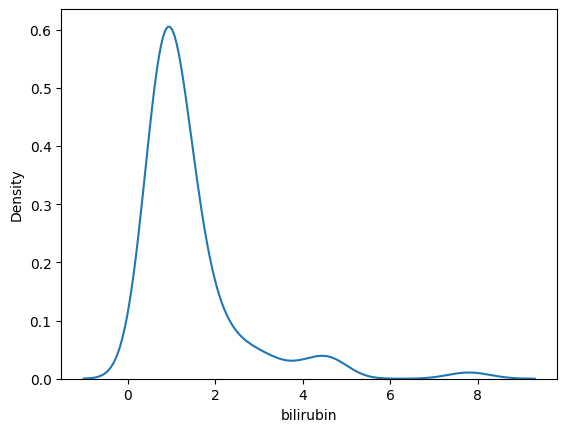

In [22]:
sns.kdeplot(df.bilirubin)

In [25]:
px.pie(df['sex'], labels = df['sex'].value_counts().index,
       values = df['sex'].value_counts().values,
       names = df['sex'].value_counts().index,
       title = 'Gender Distribution in the Data'
      )

/usr/local/lib/python3.10/dist-packages/plotly/express/_core.py:137: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return args["labels"][column]


In [27]:
features = ['age', 'sex', 'steroid', 'antivirals', 'fatigue', 'malaise', 'anorexia',
       'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites',
       'varices', 'bilirubin', 'alk_phosphate', 'sgot', 'albumin',
       'histology', 'class']
rows = 3
cols = 5
fig = make_subplots(rows=rows, cols=cols, subplot_titles=features)
x, y = np.meshgrid(np.arange(rows)+1, np.arange(cols)+1)
count  = 0
for row, col in zip(x.T.reshape(-1), y.T.reshape(-1)):
    fig.add_trace(
        go.Histogram(x = df[features[count]].values),
        row = row,
        col = col
    )
    count+=1

fig.update_layout(height=900, width=900, title_text='Feature Distribution', showlegend=False)
fig.show()

# Preprocessing

In [28]:
cat_cols = df.select_dtypes(include = ['object', 'bool']).columns.to_list()
cat_cols

['sex',
 'steroid',
 'antivirals',
 'fatigue',
 'malaise',
 'anorexia',
 'liver_big',
 'liver_firm',
 'spleen_palpable',
 'spiders',
 'ascites',
 'varices',
 'histology',
 'class']

In [29]:
le = LabelEncoder()

for i in cat_cols:
    le.fit(df[i])
    df[i] = le.transform(df[i])

In [30]:
cat_cols = df.select_dtypes(include = ['object', 'bool']).columns.to_list()
cat_cols

[]

In [31]:
df.dtypes

age                  int64
sex                  int64
steroid              int64
antivirals           int64
fatigue              int64
malaise              int64
anorexia             int64
liver_big            int64
liver_firm           int64
spleen_palpable      int64
spiders              int64
ascites              int64
varices              int64
bilirubin          float64
alk_phosphate      float64
sgot               float64
albumin            float64
protime            float64
histology            int64
class                int64
dtype: object

In [32]:
df.head()

,age,sex,steroid,antivirals,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,alk_phosphate,sgot,albumin,protime,histology,class
0,30,1,0,0,0,0,0,0,0,0,0,0,0,1.0,85.000000,18.0,4.0,100.000000,0,1
1,50,0,0,0,2,0,0,0,0,0,0,0,0,0.9,135.000000,42.0,3.5,62.280899,0,1
2,78,0,2,0,2,0,0,2,0,0,0,0,0,0.7,96.000000,32.0,4.0,62.280899,0,1
3,31,0,1,1,0,0,0,2,0,0,0,0,0,0.7,46.000000,52.0,4.0,80.000000,0,1
4,34,0,2,0,0,0,0,2,0,0,0,0,0,1.0,105.325397,200.0,4.0,62.280899,0,1


# modeling

In [33]:
X = df.drop('class',axis=1)
y = df['class']

In [34]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=0)

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
dtc = DecisionTreeClassifier(
    ccp_alpha=0.0, class_weight=None, criterion='entropy',
    max_depth=4, max_features=None, max_leaf_nodes=None,
    min_impurity_decrease=0.0, min_samples_leaf=1,
    min_samples_split=2, min_weight_fraction_leaf=0,
    random_state=42, splitter='best'
)

model = dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

dtc_acc = accuracy_score(y_test, dtc.predict(X_test))

print(f"Training Akurasi = {accuracy_score(y_train, dtc.predict(X_train))}")
print(f"Test Akurasi = {dtc_acc} \n")

Training Akurasi = 0.9351851851851852
Test Akurasi = 0.8085106382978723 



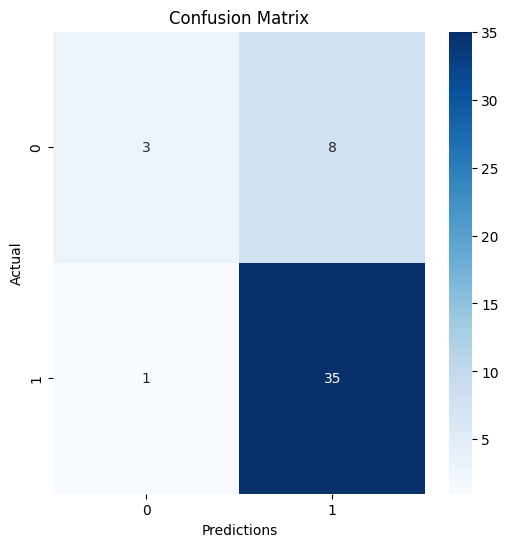

In [40]:
confusion_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=dtc.classes_, yticklabels=dtc.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.show()

In [41]:
input_data = (30,1,0,0,0,0,0,0,0,0,0,0,0,1.0,85.000000,18.0,4.0,100.000000,0)

input_data_as_numpy_array = np.array(input_data)

input_data_reshaped = input_data_as_numpy_array.reshape(1,-1)

std_data = scaler.transform(input_data_reshaped)
print(std_data)

prediction = model.predict(std_data)
print(prediction)

if (prediction[0]==1):
  print('Tidak Beresiko Kematian')
else:
  print('Beresiko Menyebabkan Kematian')

[[-0.95323741  3.53553391 -1.09221847 -0.41702883 -1.38525049 -0.78226613
  -0.5488213  -2.21892337 -0.83799808 -0.5097779  -0.71103174 -0.45143443
  -0.39056673 -0.38035403 -0.40070787 -0.83122686  0.27537154  2.11764193
  -0.86135677]]
[1]
Tidak Beresiko Kematian


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



# Visualisasi hasil algoritma

In [42]:
data_en = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)

[Text(0.5, 0.875, 'x[16] <= -0.707\nentropy = 0.711\nsamples = 108\nvalue = [21, 87]'),
 Text(0.3, 0.625, 'x[13] <= 0.576\nentropy = 0.983\nsamples = 26\nvalue = [15, 11]'),
 Text(0.2, 0.375, 'x[16] <= -1.463\nentropy = 0.964\nsamples = 18\nvalue = [7, 11]'),
 Text(0.1, 0.125, 'entropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(0.3, 0.125, 'entropy = 0.779\nsamples = 13\nvalue = [3, 10]'),
 Text(0.4, 0.375, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(0.7, 0.625, 'x[0] <= -0.424\nentropy = 0.378\nsamples = 82\nvalue = [6, 76]'),
 Text(0.6, 0.375, 'entropy = 0.0\nsamples = 35\nvalue = [0, 35]'),
 Text(0.8, 0.375, 'x[13] <= -0.763\nentropy = 0.551\nsamples = 47\nvalue = [6, 41]'),
 Text(0.7, 0.125, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.9, 0.125, 'entropy = 0.496\nsamples = 46\nvalue = [5, 41]')]

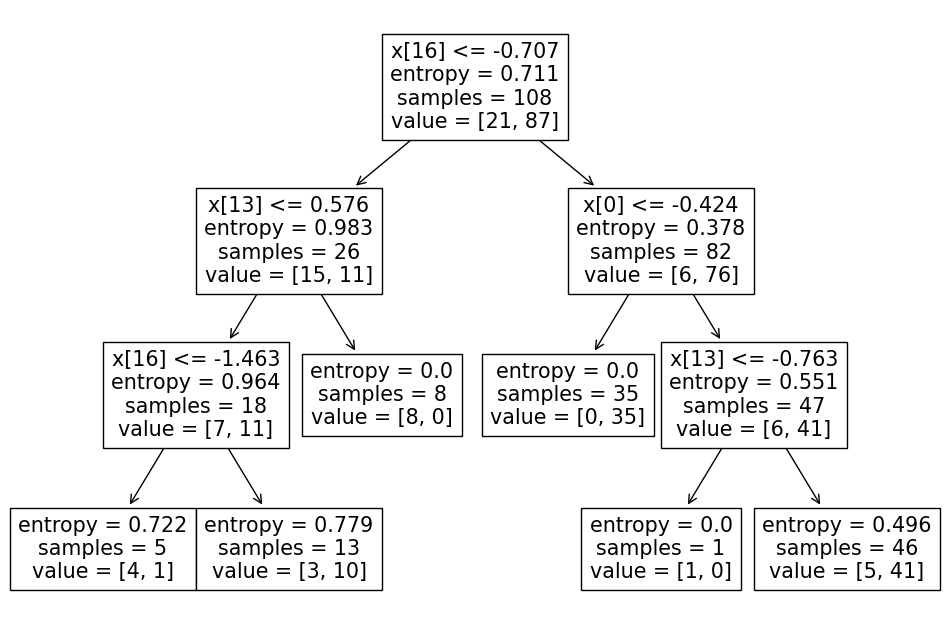

In [43]:
plt.figure(figsize=(12,8))
tree.plot_tree(data_en.fit(X_train, y_train))

# save model (pickle)

In [44]:
filename = 'model_hepatitis.sav'
pickle.dump(model, open(filename,'wb'))

In [ ]:
code 2

In [ ]:
code 3